In [1]:
# Implementing a U-net network on Bagls dataset.

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from keras import backend as keras
# import tensorflow as tf
import albumentations as A
from PIL import Image
from sklearn.model_selection import train_test_split


In [66]:
data_dir = 'D:/Hamed/Forschungsproject/Hancock 2/tiles'

x = []
y = []

for filename in natsorted(os.listdir(data_dir)):
    if filename.endswith('].png'):
        x.append(os.path.join(data_dir, filename))
        
    if filename.endswith('labelled.png'):
        y.append(os.path.join(data_dir, filename))

            


X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.01, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
overfit_X_train , overtfit_Y_train = X_train[0:5] , Y_train[0:5]
overfit_X_train , overtfit_Y_train

(['D:/Hamed/Forschungsproject/Hancock 2/tiles\\HNSCC ER 474 A [d=2.57102,x=18758,y=135256,w=1317,h=1317].png',
  'D:/Hamed/Forschungsproject/Hancock 2/tiles\\HNSCC ER 473 C [d=2.57102,x=4936,y=64173,w=1317,h=1316].png',
  'D:/Hamed/Forschungsproject/Hancock 2/tiles\\HNSCC ER 475 D [d=2.57102,x=62198,y=104651,w=1317,h=1316].png',
  'D:/Hamed/Forschungsproject/Hancock 2/tiles\\HNSCC ER 473 C [d=2.57102,x=23695,y=73058,w=1316,h=1317].png',
  'D:/Hamed/Forschungsproject/Hancock 2/tiles\\HNSCC ER 475 D [d=2.57102,x=51338,y=133282,w=1317,h=1316].png'],
 ['D:/Hamed/Forschungsproject/Hancock 2/tiles\\HNSCC ER 474 A [d=2.57102,x=18758,y=135256,w=1317,h=1317]-labelled.png',
  'D:/Hamed/Forschungsproject/Hancock 2/tiles\\HNSCC ER 473 C [d=2.57102,x=4936,y=64173,w=1317,h=1316]-labelled.png',
  'D:/Hamed/Forschungsproject/Hancock 2/tiles\\HNSCC ER 475 D [d=2.57102,x=62198,y=104651,w=1317,h=1316]-labelled.png',
  'D:/Hamed/Forschungsproject/Hancock 2/tiles\\HNSCC ER 473 C [d=2.57102,x=23695,y=73058,

In [3]:
print("Dataset Sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


Dataset Sizes:
Training set: 882 samples
Validation set: 98 samples
Test set: 10 samples


In [5]:
import numpy as np
from PIL import Image

j= 100

mask_img = Image.open(y[j])
mask_arr = np.array(mask_img) #(512, 512)
unique = np.arange(1, 13, 1) #1:12


# Create an empty array to store the channels
channels = np.zeros((mask_arr.shape[0], mask_arr.shape[1], 13), dtype=np.uint8) # 13 including background

# Assign the pixel values to the corresponding channels
for i, value in enumerate(unique):
    channels[:, :, i] = (mask_arr == value).astype(np.uint8) * 255


print(channels[:, :].shape)

(512, 512, 13)


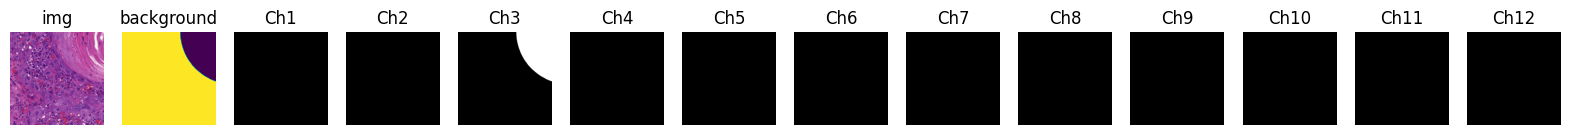

(512, 512, 3)

In [6]:
fig, axs = plt.subplots(1, 14, figsize=(20, 10))


img = Image.open(x[j])
img_arr = np.array(img)
axs[0].imshow(img_arr)
axs[0].set_title(f'img')
axs[0].axis('off')


axs[1].imshow(mask_arr == 0)
axs[1].axis('off')
axs[1].set_title('background')

for i in range(2,14):
    axs[i].imshow(channels[:, :, i-1], cmap='gray')  # Use 'cmap='gray'' for grayscale images
    axs[i].axis('off')  # Remove axes
    axs[i].set_title(f'Ch{i-1}')

plt.show()
np.shape(img_arr)

In [4]:
## gen
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, list_lables, batch_size=2, shuffle=True,aug=True):
        'Initialization'
        self.filter = A.Compose([
            A.HorizontalFlip(p=0.2),
            A.RandomBrightnessContrast(p=0.2),
            A.VerticalFlip(p=0.2),
            A.RandomRotate90(p=0.1)
        ])
        self.batch_size = batch_size
        self.list_labels = list_lables
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.aug = aug
        self.unique = np.arange(1, 13, 1)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_paths = [self.list_IDs[k] for k in indexes]
        list_lable_paths = [self.list_labels[k] for k in indexes]
        
        # Generate data
        X,y = self.__data_generation(list_IDs_paths,list_lable_paths)

        return X,y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_paths, list_lable_paths):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        x_images = []
        y_images = []

        # Generate data
        for i, (sample_path, label_path) in enumerate(zip(list_IDs_paths, list_lable_paths)):
            # Store sample
            img_arr = Image.open(sample_path)
            #img_arr = img_arr.convert("L")
            img_arr = img_arr.resize((256, 256))
            img_arr = np.array(img_arr, dtype=np.float32)
            img_arr = np.divide(img_arr, np.max(img_arr))  # normalize

            # Store label
            lbl_arr = Image.open(label_path)
            lbl_arr = lbl_arr.resize((256, 256))
            lbl_arr = np.array(lbl_arr)
            channels = np.zeros((np.shape(lbl_arr)[0], np.shape(lbl_arr)[1], 13), dtype=np.float32) # 13 including background

            for i, value in enumerate(self.unique):
                channels[:, :, i+1] = (lbl_arr == value).astype(np.uint8) * 255
            channels[:, :, 0] = (lbl_arr == 0)    
            lbl_arr = channels
            lbl_arr[lbl_arr < 1] = 0
            lbl_arr[lbl_arr >= 1] = 1
            
            if self.aug:
                transformed = self.filter(image=img_arr, mask=lbl_arr)
                x_images.append(transformed['image'])
                y_images.append(transformed['mask'])
            else: 
                x_images.append(img_arr)
                y_images.append(lbl_arr)

        # Stack x_images along a new axis
        x_images = np.stack(x_images, axis=0)
        y_images = np.stack(y_images, axis=0)

        return x_images, y_images


    def viz(self, x_images,y_images):
        'Visualizes original and transformed images'
        batch_size = len(x_images)
        for dx in range(batch_size):
            
            y_mask = y_images[dx]

                
            # Display original and transformed images side by side
            fig, axs = plt.subplots(1, 14, figsize=(20, 10))


            axs[0].imshow(x_images[dx])
            axs[0].set_title('img')
            axs[0].axis('off')



            axs[1].imshow(y_mask[:,:,0])
            axs[1].axis('off')
            axs[1].set_title('Ch1 (background)', fontsize=9)

            for i in range(2,14):
                axs[i].imshow(y_mask[:, :, i-1], cmap='gray')  # Use 'cmap='gray'' for grayscale images
                axs[i].axis('off')  # Remove axes
                axs[i].set_title(f'Class {i-1}')

            plt.show()

            
        print(f'Batch shape {np.shape(x_images)} and for masks {np.shape(y_images)}')
        print(f'image shape {np.shape(x_images[dx])} and for masks {np.shape(y_images[dx])}')
        print(f'max value for images is {np.max(x_images[dx])} and for masks {np.max(y_images[dx])}')
        print(f'min value for images is {np.min(x_images[dx])} and for masks {np.min(y_images[dx])}')
        print(f'number of unique values in images is {len(np.unique(x_images[dx]))} and for masks {np.unique(y_images[dx])}')

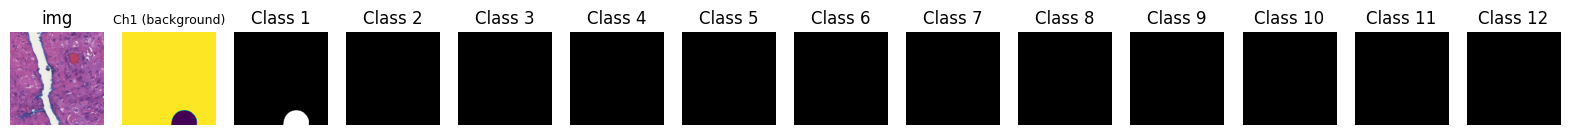

Batch shape (1, 256, 256, 3) and for masks (1, 256, 256, 13)
image shape (256, 256, 3) and for masks (256, 256, 13)
max value for images is 1.0 and for masks 1.0
min value for images is 0.19044597446918488 and for masks 0.0
number of unique values in images is 249 and for masks [0. 1.]


In [5]:
test = DataGenerator(x,y,batch_size=1,aug=1)
a,b = test.__getitem__(50)
test.viz(a,b)

In [94]:

fil = 4
inputs = Input((256, 256,3))


# Contractive
conv1 = Conv2D(fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(fil*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(fil*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(fil*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(fil*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(fil*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(fil*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(fil*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(fil*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
conv5 = BatchNormalization()(conv5)

# Expansive
upconv1 = Conv2D(fil*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
up6 = UpSampling2D(size = (2,2))(upconv1)
merge6 = concatenate([conv4,up6], axis = 3)
conv6 = Conv2D(fil*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(fil*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

upconv2 = Conv2D(fil*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
up7 = UpSampling2D(size = (2,2))(upconv2)
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(fil*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(fil*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

upconv3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
up8 = UpSampling2D(size = (2,2))(upconv3)
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(fil*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(fil*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
conv8 = BatchNormalization()(conv8)


upconv4 = Conv2D(fil*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
up9 = UpSampling2D(size = (2,2))(upconv4)
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = BatchNormalization()(conv9)


conv10 = Conv2D(13, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = conv10)

#model.summary()




In [20]:
from keras.callbacks import EarlyStopping

earlystop_callback = EarlyStopping(
    monitor='loss', 
    min_delta=0.0001,
    patience=5,
    verbose=1, 
    mode='auto' 
)

from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import IOUScore

loss = DiceLoss()
metric = IOUScore()

def custom_loss(y_true, y_pred):
    y_true_exclude_first = y_true[:, :, :, 1:]
    y_pred_exclude_first = y_pred[:, :, :, 1:]
    return loss(y_true_exclude_first, y_pred_exclude_first)

# Define custom metric excluding the first channel
def custom_metric(y_true, y_pred):
    y_true_exclude_first = y_true[:, :, :, 1:]
    y_pred_exclude_first = y_pred[:, :, :, 1:]
    return metric(y_true_exclude_first, y_pred_exclude_first)


In [110]:
model.compile(optimizer = Adam(learning_rate=0.0001), loss=custom_loss, metrics=[custom_metric])
history = model.fit(DataGenerator(X_train, Y_train, batch_size=32), 
                    epochs=1, 
                    validation_data=DataGenerator(X_val, Y_val, batch_size=32))

27/27 [==============================] - 22s 753ms/step - loss: 0.9655 - custom_metric: 0.0189 - val_loss: 0.9681 - val_custom_metric: 0.0175


In [104]:
# overfiting

DataGen = DataGenerator(overfit_X_train, overtfit_Y_train, batch_size=1,aug=False)
a, b = DataGen.__getitem__(0)

model.compile(optimizer = Adam(learning_rate=0.001), loss=custom_loss, metrics=[custom_metric])
history = model.fit(a,b, 
                    epochs=30)

Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 0.9887 - custom_metric: 0.0061
Epoch 2/30
1/1 [==============================] - 0s 27ms/step - loss: 0.9867 - custom_metric: 0.0072
Epoch 3/30
1/1 [==============================] - 0s 32ms/step - loss: 0.9856 - custom_metric: 0.0079
Epoch 4/30
1/1 [==============================] - 0s 29ms/step - loss: 0.9849 - custom_metric: 0.0083
Epoch 5/30
1/1 [==============================] - 0s 36ms/step - loss: 0.9842 - custom_metric: 0.0087
Epoch 6/30
1/1 [==============================] - 0s 40ms/step - loss: 0.9835 - custom_metric: 0.0092
Epoch 7/30
1/1 [==============================] - 0s 44ms/step - loss: 0.9829 - custom_metric: 0.0095
Epoch 8/30
1/1 [==============================] - 0s 42ms/step - loss: 0.9824 - custom_metric: 0.0098
Epoch 9/30
1/1 [==============================] - 0s 41ms/step - loss: 0.9820 - custom_metric: 0.0101
Epoch 10/30
1/1 [==============================] - 0s 27ms/step - loss: 0.9816 - cus

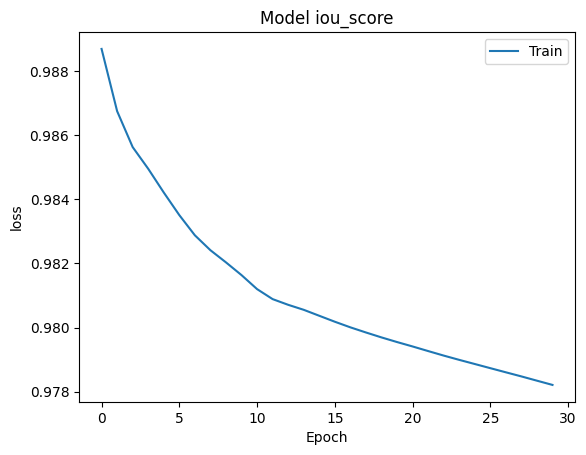

In [109]:
#how was the network on each epoch?

plt.plot(history.history['loss'])
plt.title('Model iou_score')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [111]:
DataGen = DataGenerator(X_test, Y_test, batch_size=len(X_test),aug=True)
a, b =DataGen.__getitem__(0)
score = model.evaluate(a,b)


1/1 [==============================] - 0s 54ms/step - loss: 0.9727 - custom_metric: 0.0145


1/1 [==============================] - 0s 21ms/step


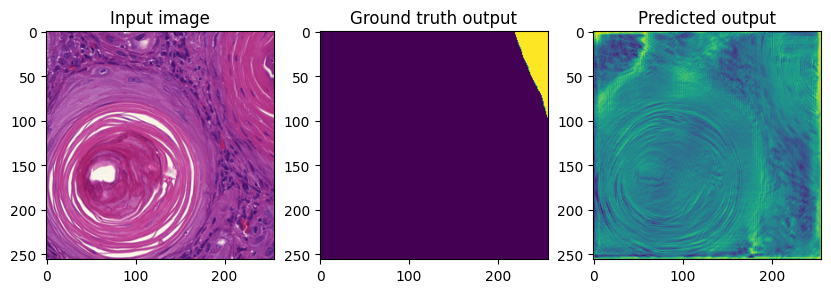

In [126]:
test = DataGenerator(x,y,batch_size=1,aug=False)
img,mask = test.__getitem__(2)
y_pred = model.predict(img)

# Create a figure with three subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Plot the input image in the first subplot
axs[0].imshow(img[0])
axs[0].set_title('Input image')

# Create an empty array to store the changed image
changed_img = np.zeros((10, 256, 256, 1), dtype=np.uint8)

# Iterate over the channels and assign values accordingly
for i in range(13):
    temp = (mask[:,:, :, i] == 1.).astype(np.uint8)
    changed_img[:, :, :, 0] += temp * (i + 1)
    
mask = changed_img


# Plot the ground truth output in the second subplot
axs[1].imshow(np.sum(mask[0],axis=2))
axs[1].set_title('Ground truth output')

# Plot the predicted output in the third subplot
axs[2].imshow(np.sum(y_pred[0],axis=2))
axs[2].set_title('Predicted output')

# Show the figure
plt.show()
